In [1]:
#Perceptron Multicapa
# https://relopezbriega.github.io/blog/2016/06/05/tensorflow-y-redes-neuronales/

In [2]:
# importamos la libreria
import tensorflow as tf

# importamos librerías adicionales
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

In [3]:
# importando el dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# forma del dataset 55000 imagenes
mnist.train.images.shape

(55000, 784)

In [5]:
# cada imagen es un array de 28x28 con cada pixel 
# definido como escala de grises.
digito1 = mnist.train.images[0].reshape((28, 28))

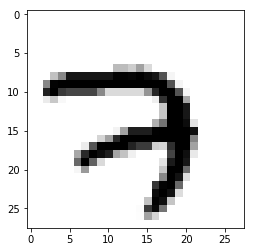

In [6]:
# visualizando el primer digito
plt.imshow(digito1, cmap = cm.Greys)
plt.show()

In [7]:
# valor correcto
mnist.train.labels[0].nonzero()[0][0]

7

In [8]:
# visualizando imagenes de 5 en 5
def visualizar_imagenes(dataset, cant_img):
    img_linea = 5
    lineas = int(cant_img / img_linea)
    imagenes = []
    for i in range(lineas):
        datos = []
        for img in dataset[img_linea* i:img_linea* (i+1)]:
            datos.append(img.reshape((28,28)))
            imgs = np.hstack(datos)
        imagenes.append(imgs)
    data = np.vstack(imagenes)
    plt.imshow(data, cmap = cm.Greys )
    plt.show()

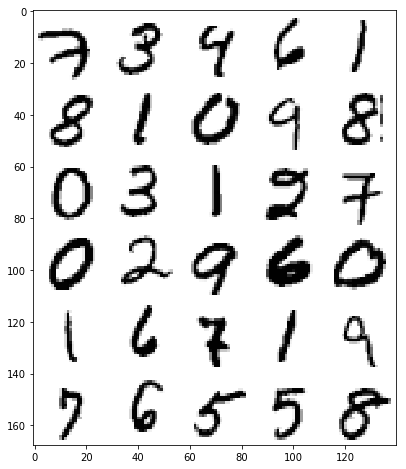

In [9]:
# visualizando los primeros 30 dígitos
plt.figure(figsize=(8, 8))
visualizar_imagenes(mnist.train.images, 30)

In [10]:
#Construyendo el perceptron

In [11]:
# Parametros
tasa_aprendizaje = 0.001
epocas = 15
lote = 100
display_step = 1
logs_path = "/tmp/tensorflow_logs/perceptron"

# Parametros de la red
n_oculta_1 = 256 # 1ra capa de atributos
n_oculta_2 = 256 # 2ra capa de atributos
n_entradas = 784 # datos de MNIST(forma img: 28*28)
n_clases = 10 # Total de clases a clasificar (0-9 digitos)

# input para los grafos
x = tf.placeholder("float", [None, n_entradas],  name='DatosEntrada')
y = tf.placeholder("float", [None, n_clases], name='Clases')

In [12]:
# Creamos el modelo
def perceptron_multicapa(x, pesos, sesgo):
    # Función de activación de la capa escondida
    capa_1 = tf.add(tf.matmul(x, pesos['h1']), sesgo['b1'])
    # activacion relu
    capa_1 = tf.nn.relu(capa_1)
    # Función de activación de la capa escondida
    capa_2 = tf.add(tf.matmul(capa_1, pesos['h2']), sesgo['b2'])
    # activación relu
    capa_2 = tf.nn.relu(capa_2)
    # Salida con activación lineal
    salida = tf.matmul(capa_2, pesos['out']) + sesgo['out']
    return salida

In [20]:
# Definimos los pesos y sesgo de cada capa.
pesos = {
    'h1': tf.Variable(tf.random_normal([n_entradas, n_oculta_1])),
    'h2': tf.Variable(tf.random_normal([n_oculta_1, n_oculta_2])),
    'out': tf.Variable(tf.random_normal([n_oculta_2, n_clases]))
}
sesgo = {
    'b1': tf.Variable(tf.random_normal([n_oculta_1])),
    'b2': tf.Variable(tf.random_normal([n_oculta_2])),
    'out': tf.Variable(tf.random_normal([n_clases]))
}

with tf.name_scope('Modelo'):
    # Construimos el modelo
    pred = perceptron_multicapa(x, pesos, sesgo)

with tf.name_scope('Costo'):
    # Definimos la funcion de costo
    costo = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
                           #tf.nn.softmax_cross_entropy_with_logits(logits = yPredbyNN, labels=Y)
    
with tf.name_scope('optimizador'):
    # Algoritmo de optimización
    optimizar = tf.train.AdamOptimizer(
        learning_rate=tasa_aprendizaje).minimize(costo)

with tf.name_scope('Precision'):
    # Evaluar el modelo
    pred_correcta = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calcular la precisión
    Precision = tf.reduce_mean(tf.cast(pred_correcta, "float"))
    
# Inicializamos todas las variables
init = tf.global_variables_initializer()

# Crear sumarización para controlar el costo
tf.summary.scalar("Costo", costo)
# Crear sumarización para controlar la precisión
tf.summary.scalar("Precision", Precision)
# Juntar los resumenes en una sola operación
merged_summary_op = tf.summary.merge_all()

In [25]:
#Lanzamos la sesión
with tf.Session() as sess:
    sess.run(init)
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(
        logs_path, graph=tf.get_default_graph())

    # Entrenamiento
    for epoca in range(epocas):
        avg_cost = 0.
        lote_total = int(mnist.train.num_examples/lote)

        for i in range(lote_total):
            lote_x, lote_y = mnist.train.next_batch(lote)
            # Optimización por backprop y funcion de costo
            _, c, summary = sess.run([optimizar, costo, merged_summary_op],
                                     feed_dict={x: lote_x, y: lote_y})
            # escribir logs en cada iteracion
            summary_writer.add_summary(summary, epoca * lote_total + i)
            # perdida promedio
            avg_cost += c / lote_total
        # imprimir información de entrenamiento
        if epoca % display_step == 0:
            print("Iteración: {0: 04d} costo = {1:.9f}".format(epoca+1, 
                                                            avg_cost))
    print("Optimización Terminada!\n")

    
    print("Precisión: {0:.2f}".format(Precision.eval({x: mnist.test.images,
                                                y: mnist.test.labels})))

    print("Ejecutar el comando:\n",
          "--> tensorboard --logdir=/tmp/tensorflow_logs ",
          "\nLuego abir https://0.0.0.0:6006/ en el navegador")



Iteración:  001 costo = 155.600329645
Iteración:  002 costo = 38.129101190
Iteración:  003 costo = 23.991320412
Iteración:  004 costo = 16.807139936
Iteración:  005 costo = 12.214856211
Iteración:  006 costo = 8.963069011
Iteración:  007 costo = 6.658746676
Iteración:  008 costo = 4.993170436
Iteración:  009 costo = 3.746032354
Iteración:  010 costo = 2.880087869
Iteración:  011 costo = 2.033952957
Iteración:  012 costo = 1.533638166
Iteración:  013 costo = 1.196034541
Iteración:  014 costo = 0.958940321
Iteración:  015 costo = 0.722351129
Optimización Terminada!

Precisión: 0.94
('Ejecutar el comando:\n', '--> tensorboard --logdir=/tmp/tensorflow_logs ', '\nLuego abir https://0.0.0.0:6006/ en el navegador')
